# belief eye neural analysis


### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [3]:
# analysis
from scipy.io import loadmat
from sklearn.decomposition import FastICA
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_decomposition import CCA

In [4]:
# misc
import pickle
from collections import defaultdict

In [5]:
from neural_plot_ult import *
import time
tic=time.time()
import warnings
warnings.filterwarnings('ignore')

# load data

In [6]:
df = pd.read_pickle(resdir/'0618_m51df.pkl')
len(df)
df=df[df.session==41]

In [7]:
def process_one(y):
    related_taskvar=np.array(normalize_z(y))
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    related_taskvar[~mask]=0
    return related_taskvar, mask

def process(rawtaskvar, returnmask=False):
    # normalize each item to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    related_taskvar=np.vstack(rawtaskvar).T
    # related_taskvar=np.clip(related_taskvar,-4,4)
    mask=(related_taskvar > -4) & (related_taskvar < 4)
    mask=np.all(mask, axis=1)
    related_taskvar=related_taskvar[mask]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar
def process_list(rawtaskvar, returnmask=False):
    # normalize each item to 0 mean 1 std
    rawtaskvar=[np.array(normalize_z(y)) for y in rawtaskvar]
    mask=[(a > -4) & (a < 4) for a in rawtaskvar]
    mask=np.all(mask)
    related_taskvar=[a[mask] for a in rawtaskvar]
    if returnmask:
        return related_taskvar, mask
    return related_taskvar

In [8]:
# error distribution
def get_stop_error(row):
    return ((row.fx[-1]-row.mx[-1])**2+(row.fy[-1]-row.my[-1])**2)**0.5
df['state_error']=df.apply(get_stop_error, axis=1)
def get_stop_error(row):
    return ((row.fx[-1]-row.bmx[-1])**2+(row.fy[-1]-row.bmy[-1])**2)**0.5
df['belief_error']=df.apply(get_stop_error, axis=1)

# time ratio
df['time_ratio']=df.apply(lambda x: x.timer/x.timer[-1], axis=1)


In [9]:
for session in sorted(df.session.unique())[:1]:
    sessdf=df[(df.session==session)]

state=np.concatenate(sessdf.belief_ff_hori.to_numpy())
belief=np.concatenate(sessdf.ff_hori.to_numpy())
eye=np.concatenate(sessdf.eye_hori.to_numpy())
timeratio=np.concatenate(sessdf.time_ratio.to_numpy())
timer=np.concatenate(sessdf.timer.to_numpy())
countdown=np.concatenate(sessdf.countdown.to_numpy())


In [10]:
df.columns

Index(['trial', 'session', 'fullon', 'density', 'eye_hori', 'eye_vert',
       'ff_hori', 'ff_vert', 'fx', 'fy', 'mx', 'my', 'mv', 'mw', 'PPC', 'PFC',
       'MST', 'error', 'error_sign', 'target_angle', 'target_distance',
       'state', 'action', 'task', 'likelihood', 'belief', 'rawcov', 'bmx',
       'bmy', 'heading', 'belief_heading', 'timer', 'countdown',
       'belief_ff_hori', 'belief_ff_vert', 'angle_from_start',
       'belief_angle_from_start', 'relcov', 'state_error', 'belief_error',
       'time_ratio'],
      dtype='object')

In [11]:
# make a df by time (each row is a time, instead of a trial)
sessdf['density_t']=sessdf.apply(lambda x: np.array([[x.density]*len(x.mx)]).reshape(-1), axis=1)
sessdf['fullon_t']=sessdf.apply(lambda x: np.array([[x.fullon]*len(x.mx)]).reshape(-1), axis=1)
sessdf['error_t']=sessdf.apply(lambda x: np.array([[x.error]*len(x.mx)]).reshape(-1), axis=1)
sessdf['triallen_t']=sessdf.apply(lambda x: np.array([[len(x.mx)]*len(x.mx)]).reshape(-1), axis=1)

timedf=pd.DataFrame({'timer':timer})
timedf['rawcov']=list(np.vstack(sessdf['rawcov'].to_numpy()))
timedf['belief']=np.concatenate(sessdf.belief_ff_hori.to_numpy())
timedf['state']=np.concatenate(sessdf.ff_hori.to_numpy())
timedf['eye']=np.concatenate(sessdf.eye_hori.to_numpy())
timedf['timeratio']=np.concatenate(sessdf.time_ratio.to_numpy())
timedf['mv']=np.concatenate(sessdf.mv.to_numpy())
timedf['mw']=np.concatenate(sessdf.mw.to_numpy())
timedf['belief_heading']=np.concatenate(sessdf.belief_heading.to_numpy())
timedf['timer']=np.concatenate(sessdf.timer.to_numpy())
timedf['countdown']=np.concatenate(sessdf.countdown.to_numpy())
timedf['belief_angle_from_start']=np.concatenate(sessdf.belief_angle_from_start.to_numpy())
timedf['PPC']=list(np.vstack(sessdf.PPC.to_numpy()))

timedf['uncertainty']=list(np.concatenate(sessdf.relcov.to_numpy()))

timedf['density']=np.concatenate(sessdf.density_t.to_numpy())
timedf['fullon']=np.concatenate(sessdf.fullon_t.to_numpy())
timedf['error']=np.concatenate(sessdf.error_t.to_numpy())


timedf['dbelief']=np.concatenate(sessdf.apply(lambda x: np.diff(x.belief_ff_hori, prepend=x.belief_ff_hori[:1],axis=0),axis=1).to_numpy())
timedf['deye']=np.concatenate(sessdf.apply(lambda x: np.diff(x.eye_hori, prepend=x.eye_hori[:1],axis=0),axis=1).to_numpy())
timedf['dneural']=list(np.vstack(sessdf.apply(lambda x: np.diff(x.PPC, prepend=x.PPC[:1], axis=0),axis=1).to_numpy()))


timedf.head()
timedf = timedf.dropna(subset=['eye', 'state', 'belief'])

# work

What we want to see is beh belief correlates with neural belief, conditinoed on obs:
Same obs, similar update, no control over others, so diff prections, diff neural activity
this showing update mainly depends on obs, the residual is correlated.


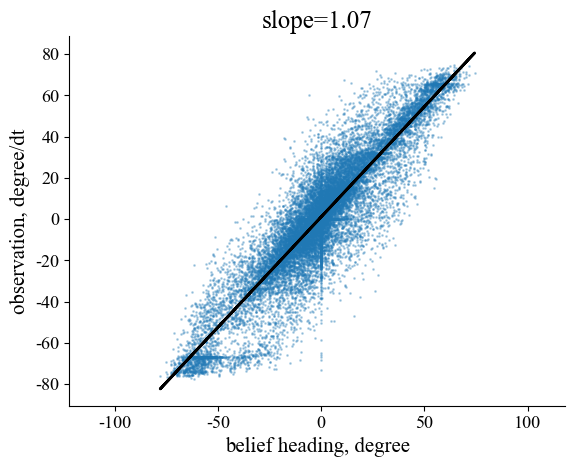

(-92.3082260131836, 81.74606170654297, -104.20923461914063, 94.50676574707032)

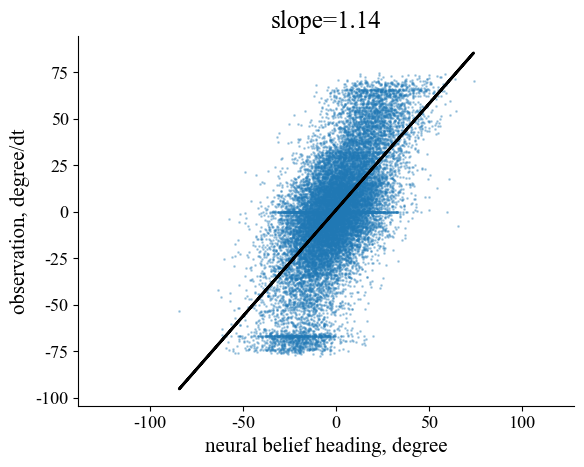

In [17]:
'''
beh and neural belief delta, vs obs.
'''
from sklearn.linear_model import LinearRegression
behaviorbeliefheading, observation=10*np.concatenate([np.diff(a) for a in sessdf.belief_heading.to_numpy()]), np.concatenate([a[:-1] for a in sessdf.mw.to_numpy()])
neural_data=np.concatenate([a[:-1] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, behaviorbeliefheading)
neuralheading=model.predict(neural_data)
residual=np.abs(neuralheading-behaviorbeliefheading)

fig,ax=plt.subplots(1,1)
plt.scatter(behaviorbeliefheading,observation,s=1,alpha=0.3)
s=plot_best_fit(behaviorbeliefheading, observation, ax)
plt.title(f'slope={s:.2f}')
plt.xlabel('belief heading, degree')
plt.ylabel('observation, degree/dt')
plt.axis('equal')
plt.show()

fig,ax=plt.subplots(1,1)
plt.scatter(neuralheading,observation,s=1,alpha=0.3)
s=plot_best_fit(neuralheading, observation, ax)
plt.title(f'slope={s:.2f}')
plt.xlabel('neural belief heading, degree')
plt.ylabel('observation, degree/dt')
plt.axis('equal')

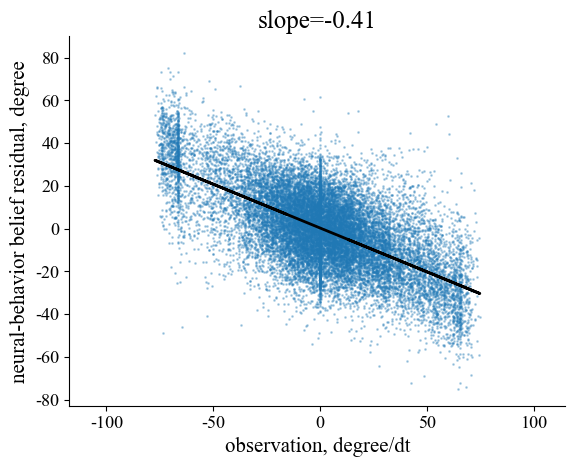

In [56]:
'''
beh and neural delta residual, vs obs
'''
from sklearn.linear_model import LinearRegression
behaviorbeliefheading, observation=10*np.concatenate([np.diff(a) for a in sessdf.belief_heading.to_numpy()]), np.concatenate([a[:-1] for a in sessdf.mw.to_numpy()])
neural_data=np.concatenate([a[:-1] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, behaviorbeliefheading)
neuralheading=model.predict(neural_data)
residual=(neuralheading-behaviorbeliefheading)

fig,ax=plt.subplots(1,1)
plt.scatter(observation, residual,s=1,alpha=0.3)
s=plot_best_fit(observation, residual, ax)
plt.title(f'slope={s:.2f}')
plt.ylabel('neural-behavior belief residual, degree')
plt.xlabel('observation, degree/dt')
plt.axis('equal') 
plt.show()



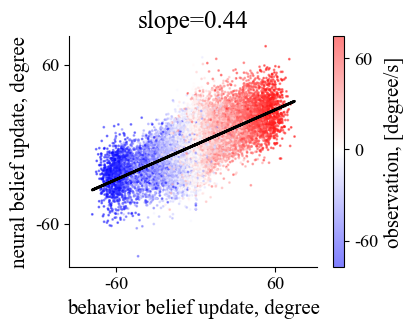

In [54]:
'''
delta vs delta, color by obs
simlar plot to rational code paper.
'''
from sklearn.linear_model import LinearRegression, Lasso, Ridge
behaviorbeliefheading, observation=10*np.concatenate([np.diff(a) for a in sessdf.belief_heading.to_numpy()]), np.concatenate([a[:-1] for a in sessdf.mw.to_numpy()])
neural_data=np.concatenate([a[:-1] for a in sessdf.PPC.to_numpy()])
model = LinearRegression()
model.fit(neural_data, behaviorbeliefheading)
neuralheading=model.predict(neural_data)
residual=(neuralheading-behaviorbeliefheading)

fig,ax=plt.subplots(1,1,figsize=(4,3))
c=plt.scatter(behaviorbeliefheading, neuralheading, c=observation, cmap='bwr',s=1,alpha=0.5)
plt.colorbar(c, label=f'observation, [degree/s]', ticks=[-60,0,60])

s=plot_best_fit(behaviorbeliefheading, neuralheading, ax)
plt.title(f'slope={s:.2f}')
plt.xticks([-60,60])
plt.yticks([-60,60])
plt.ylabel(r'neural belief update, degree')
plt.xlabel(r'behavior belief update, degree')
plt.axis('equal') 
plt.show()
